# Results Analysis
Author: Oscar Janossy   
Date: 2025-05-19  
Description: Analysis of the results and assesment of perfromance

In [ ]:
import pandas as pd
import numpy as np
from math import log10, floor
from typing import Optional

import matplotlib.pyplot as plt

## Import results

In [2]:
true_values = pd.read_csv('/Users/oscar/Documents/VS Code/Thesis/data/test_values.csv', index_col=0, parse_dates=True)
true_values.index.name = 'start_date'
true_values

,Imbalance
start_date,
2023-12-12 17:00:00+00:00,465.69
2023-12-12 17:30:00+00:00,340.22
2023-12-12 18:00:00+00:00,-133.64
2023-12-12 18:30:00+00:00,219.71
2023-12-12 19:00:00+00:00,-77.95
...,...
2024-12-29 20:30:00+00:00,-83.22
2024-12-29 21:00:00+00:00,39.56
2024-12-29 21:30:00+00:00,-320.48


In [3]:
lgbm = pd.read_csv("/Users/oscar/Documents/VS Code/Thesis/data/predictions_lgbm.csv", index_col=0, parse_dates=True)
lgbm.index.name = 'start_date'
lgbm.rename(columns={'pred': 'lgbm'}, inplace=True)
lgbm.head()

,lgbm
start_date,
2023-12-12 17:00:00+00:00,441.312490
2023-12-12 17:30:00+00:00,296.432985
2023-12-12 18:00:00+00:00,142.914952
2023-12-12 18:30:00+00:00,111.854523
2023-12-12 19:00:00+00:00,-105.814447


In [4]:
sarima = pd.read_csv("/Users/oscar/Documents/VS Code/Thesis/data/predictions_sarima.csv", index_col=0, parse_dates=True)
sarima.index.name = 'start_date'
sarima.rename(columns={'0': 'sarima'}, inplace=True)
sarima.head()



,sarima
start_date,
2023-12-12 17:00:00+00:00,426.377602
2023-12-12 17:30:00+00:00,709.801361
2023-12-12 18:00:00+00:00,472.634312
2023-12-12 18:30:00+00:00,164.926864
2023-12-12 19:00:00+00:00,97.724197


In [5]:
naive = pd.read_csv("/Users/oscar/Documents/VS Code/Thesis/data/prediction_naive.csv", index_col=0, parse_dates=True)
naive.rename(columns={'Imbalance_lag_1': 'naive'}, inplace=True)
naive.head()


,naive
start_date,
2023-12-12 17:00:00+00:00,81.15
2023-12-12 17:30:00+00:00,465.69
2023-12-12 18:00:00+00:00,340.22
2023-12-12 18:30:00+00:00,-133.64
2023-12-12 19:00:00+00:00,219.71


In [6]:
lstm = pd.read_csv("/Users/oscar/Documents/VS Code/Thesis/data/lstm.csv", index_col=0, parse_dates=True)
lstm.rename(columns={'Imbalance': 'lstm'}, inplace=True)
lstm.head()

,lstm
start_date,
2023-12-12 17:00:00+00:00,452.08853
2023-12-12 17:30:00+00:00,278.67830
2023-12-12 18:00:00+00:00,104.01848
2023-12-12 18:30:00+00:00,287.41638
2023-12-12 19:00:00+00:00,-236.93932


In [7]:
arima = pd.read_csv("/Users/oscar/Documents/VS Code/Thesis/data/sarima_r.csv", index_col=0, parse_dates=True)
arima.index = arima.index.tz_localize('UTC')  # Ensure the index is in UTC
# arima.index.name = 'start_date'
# arima = arima[['ARIMA']]
# arima = arima[arima.index >= naive.index.min()]
arima

,sarima
start_date,
2023-12-12 17:00:00+00:00,321.538806
2023-12-12 17:30:00+00:00,277.681810
2023-12-12 18:00:00+00:00,122.071350
2023-12-12 18:30:00+00:00,157.378748
2023-12-12 19:00:00+00:00,-193.525289
...,...
2024-12-29 20:30:00+00:00,-40.314707
2024-12-29 21:00:00+00:00,-276.032237
2024-12-29 21:30:00+00:00,-59.379063


In [8]:
df = pd.concat([true_values,lgbm, lstm, naive,arima], axis=1)
df.head()
df.to_csv('/Users/oscar/Documents/VS Code/Thesis/data/combined_predictions.csv', index=True)    

In [9]:
residuals = df.drop(columns='Imbalance').subtract(df['Imbalance'], axis=0)
residuals.head()
residuals.to_csv('/Users/oscar/Documents/VS Code/Thesis/data/residuals.csv', index=True)    

## Compute the performance

In [10]:
def sign_change_accuracy(y_true, y_pred):
    """
    Computes the Sign Change Accuracy (SCAP):
    the proportion of times the model correctly predicts
    the direction of a sign change in the true series.

    Parameters:
    - y_true: array-like of true values
    - y_pred: array-like of predicted values

    Returns:
    - sca: float (between 0 and 1)
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    if len(y_true) != len(y_pred):
        raise ValueError("Input arrays must have the same length.")

    # Compute signs of true and predicted values
    sign_true = np.sign(y_true)
    sign_pred = np.sign(y_pred)

    # Identify where the true values change sign
    sign_change_mask = sign_true[1:] != sign_true[:-1]

    # Evaluate if the model got the sign right after the change
    correct_direction = sign_pred[1:] == sign_true[1:]

    # Only consider time steps where true sign changed
    correct_on_change = correct_direction[sign_change_mask]

    # Avoid division by zero
    total_changes = np.sum(sign_change_mask)
    if total_changes == 0:
        return np.nan  # or 0.0 or raise an error depending on your preference

    # Compute SCAP
    scap = np.sum(correct_on_change) / total_changes * 100
    return scap
sign_change_accuracy(df['Imbalance'], df['lstm'])

np.float64(52.05094991364422)

In [11]:
def compute_forecast_metrics(
    df: pd.DataFrame,
    true_col: str = "Imbalance",
    benchmark_col: str = "naive",
    model_cols: Optional[list] = None,
    sig: int = 3,
) -> pd.DataFrame:
    """
    Returns MAE, RMSE, MASE and RMSSE for every prediction column.

    Only argument you must supply is the DataFrame; by default the
    ground-truth column is 'y_true' and the benchmark column is 'naive'.
    If you keep those names, just call:
        metrics = compute_forecast_metrics(df)
    """

    # auto-detect prediction columns
    if model_cols is None:
        model_cols = [c for c in df.columns if c != true_col]

    y = df[true_col]

    # benchmark errors
    bench_err = y - df[benchmark_col]
    mae_bench = np.mean(np.abs(bench_err))
    mse_bench = np.mean(np.square(bench_err))

    results = {}
    for col in model_cols:
        e = y - df[col]
        mae = np.mean(np.abs(e))
        mse = np.mean(np.square(e))
        scap = sign_change_accuracy(y, df[col])
        
        results[col] = {
            "MAE": mae,
            "RMSE": np.sqrt(mse),
            "MASE": mae / mae_bench if mae_bench else np.nan,
            "RMSSE": np.sqrt(mse / mse_bench) if mse_bench else np.nan,
            "SCAP": scap,
        }

    df_out =  pd.DataFrame(results).T.reindex(model_cols)

    # ── round to significant digits ────────────────────────────────────────────
    def _round_sig(x, s=sig):
        if x == 0 or np.isnan(x):
            return x
        return round(x, s - 1 - int(floor(log10(abs(x)))))

    return df_out.map(_round_sig)




In [12]:
df_metrics = compute_forecast_metrics(df, true_col='Imbalance', benchmark_col='naive', model_cols=['naive','sarima','lgbm', 'lstm', ])
df_metrics.to_clipboard(index=True, header=True)
df_metrics

,MAE,RMSE,MASE,RMSSE,SCAP
naive,257.0,330.0,1.000,1.000,0.0
sarima,202.0,268.0,0.788,0.810,45.5
lgbm,204.0,269.0,0.794,0.815,44.8
lstm,209.0,275.0,0.815,0.832,52.1


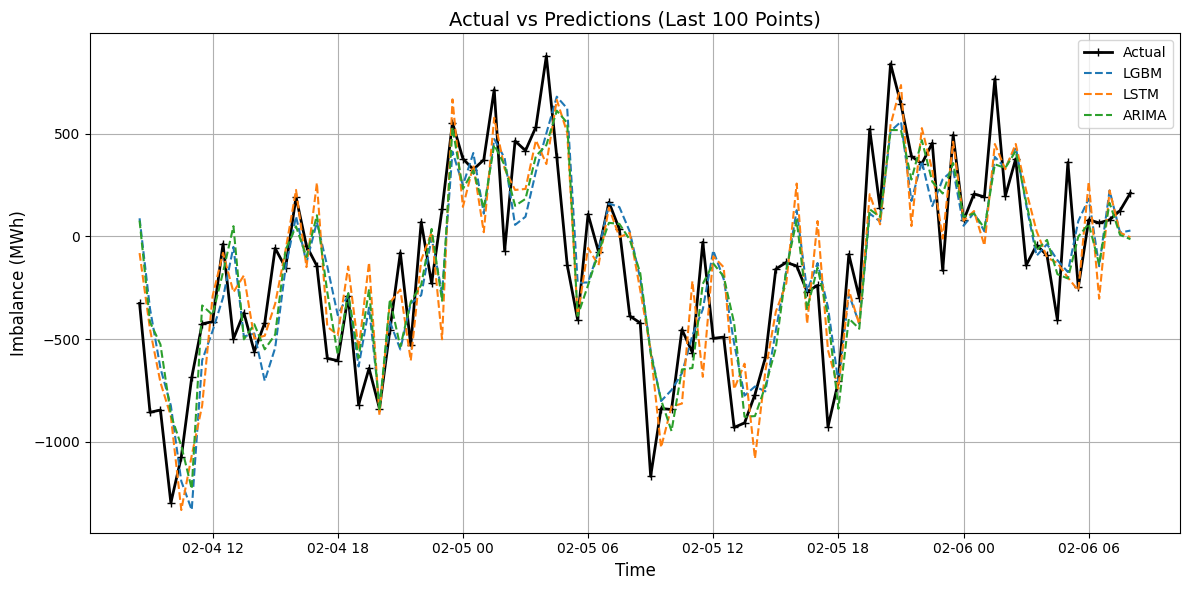

In [ ]:
np.random.seed(2)
start = np.random.randint(0, len(df)-96, 1)[0]  # Extract the integer value from the array
plot_points = df.iloc[start: start+96]


# Plot the data
# Plot
plt.figure(figsize=(12, 6))
plt.plot(plot_points.index, plot_points['Imbalance'], label='Actual', color='black', linewidth=2, marker='+')
plt.plot(plot_points.index, plot_points['lgbm'], label='LGBM', linestyle='--')
plt.plot(plot_points.index, plot_points['lstm'], label='LSTM', linestyle='--')
#plt.plot(plot_points.index, plot_points['naive'], label='Naive', linestyle='--')
#plt.plot(plot_points.index, plot_points['sarima'], label='SARIMA', linestyle='--')
plt.plot(plot_points.index, plot_points['sarima'], label='ARIMA', linestyle='--')

# Formatting
plt.title('Actual vs Predictions (Last 100 Points)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Imbalance (MWh)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

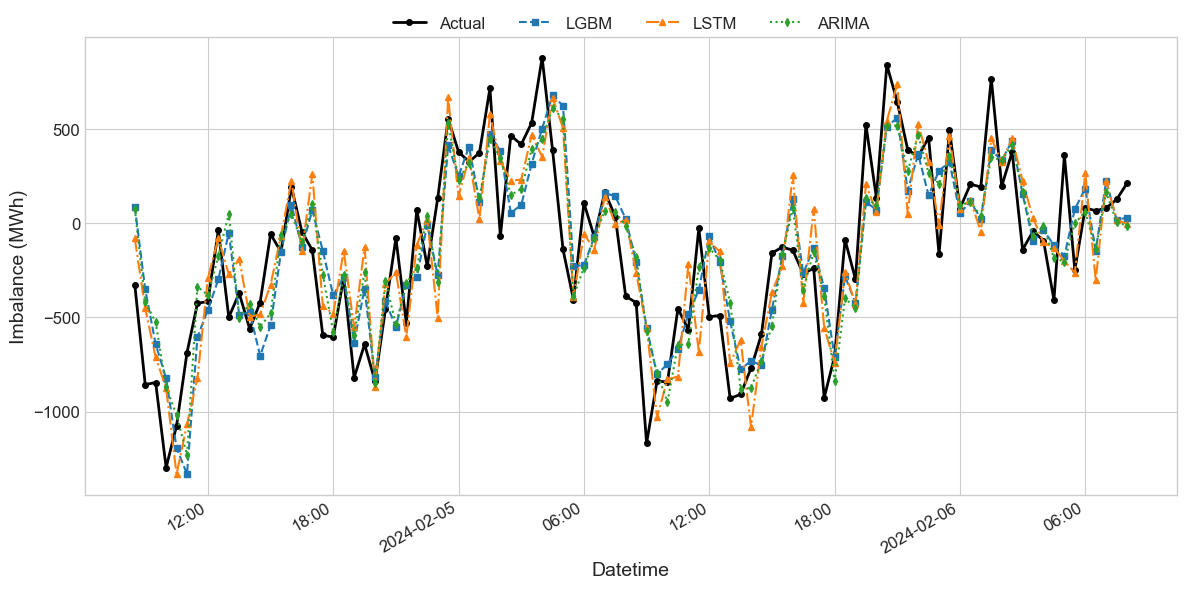

In [ ]:

import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter


# pick a reproducible window
np.random.seed(2)
start = np.random.randint(0, len(df)-96)
plot_points = df.iloc[start : start+96]

# update global font sizes
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
})
plt.style.use('seaborn-v0_8-whitegrid')

fig, ax = plt.subplots(figsize=(12, 6))
# major = every 6h, minor = every 1h
def tick_fmt(x, pos=None):
    dt = mdates.num2date(x)
    if dt.hour == 0:
        return dt.strftime('%Y-%m-%d')   # midnight → full date
    else:
        return dt.strftime('%H:%M')      # other ticks → HH:MM

ax.xaxis.set_major_formatter(FuncFormatter(tick_fmt))


ax.xaxis.get_offset_text().set_visible(False)
ax.grid(which='minor', alpha=0.2)




# plot lines
ax.plot(plot_points.index, plot_points['Imbalance'],
        label='Actual', color='k', lw=2, marker='o', markersize=4)
ax.plot(plot_points.index, plot_points['lgbm'],
        label='LGBM', color='#1f77b4', ls='--', lw=1.5, marker='s', markersize=4)
ax.plot(plot_points.index, plot_points['lstm'],
        label='LSTM', color='#ff7f0e', ls='-.', lw=1.5, marker='^', markersize=4)
ax.plot(plot_points.index, plot_points['sarima'],
        label='ARIMA', color='#2ca02c', ls=':', lw=1.5, marker='d', markersize=4)




ax.set_xlabel('Datetime')
ax.set_ylabel('Imbalance (MWh)')


# place legend centered on top, outside the plot area
ax.legend(
    loc='upper center',               # anchor point
    bbox_to_anchor=(0.5, 1.06),       # (x, y) in axes fraction coordinates
    ncol=4,                           # number of columns = number of series
    frameon=False,
    title_fontsize=12,
    borderaxespad=0                  # padding between axes and legend
)


fig.autofmt_xdate()

# Remove the background
fig.patch.set_alpha(0.0)
ax.set_facecolor('none')
plt.tight_layout(pad=1.0)

# save high-res for reports
fig.savefig('oos_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [16]:
plot_points

,Imbalance,lgbm,lstm,naive,sarima
start_date,,,,,
2024-02-04 08:30:00+00:00,-326.15,88.565589,-80.801330,-105.08,77.550952
2024-02-04 09:00:00+00:00,-856.73,-351.838891,-452.521600,-326.15,-416.898940
2024-02-04 09:30:00+00:00,-845.70,-641.863810,-711.223600,-856.73,-525.833092
2024-02-04 10:00:00+00:00,-1297.98,-824.164130,-876.472840,-845.70,-869.316631
2024-02-04 10:30:00+00:00,-1074.98,-1192.447561,-1332.944500,-1297.98,-1019.821757
...,...,...,...,...,...
2024-02-06 06:00:00+00:00,81.54,184.299455,266.608340,-248.23,61.513190
2024-02-06 06:30:00+00:00,66.14,-144.880267,-303.032560,81.54,-134.722353
2024-02-06 07:00:00+00:00,81.18,224.536428,224.036620,66.14,163.622426


## Diebold-Mariano test

In [70]:
import pandas as pd
from rpy2.robjects import pandas2ri, FloatVector
from rpy2.robjects.packages import importr
from itertools import combinations

# Activate pandas2ri to convert pandas DataFrames to R dataframes automatically
pandas2ri.activate()

# Import the forecast package from R
forecast = importr("forecast")



# Convert each residual column to R vectors
lstm_residuals = FloatVector(residuals['lstm'].tolist())
sarima_residuals = FloatVector(residuals['sarima'].tolist())
naive_residuals = FloatVector(residuals['naive'].tolist())
lgbm_residuals = FloatVector(residuals['lgbm'].tolist())

# Create unique combinations of residuals where order does not matter
residual_names = [("BiLSTM", lstm_residuals), 
                  ("SARIMA", sarima_residuals), 
                  ("NAIVE", naive_residuals), 
                  ("LightGBM", lgbm_residuals)]

residual_combinations = [(res1[1], res2[1], (res1[0], res2[0])) for res1, res2 in combinations(residual_names, 2)]


# Perform the Diebold-Mariano test
dm_df = pd.DataFrame(columns=['model A','model B','statistic', 'p_value'])

for residual1, residual2, residual_name in residual_combinations:
    dm_test_result = forecast.dm_test(residual1, residual2, h=1, power=2, varestimator = "acf")

    statistic = round(dm_test_result.rx2('statistic')[0],3)
    p_value = round(dm_test_result.rx2('p.value')[0] ,3)
    dm_df = pd.concat([dm_df, pd.DataFrame({'model A': [residual_name[0]],'model B': [residual_name[1]], 'statistic': [statistic], 'p_value': [p_value]})], ignore_index=True)


# # Print the test result
print(dm_df)

# Ensure that the DataFrame being concatenated is not empty or all-NA
dm_df.to_clipboard(index=False, header=False)



  model A   model B  statistic  p_value
0  BiLSTM    SARIMA      7.276    0.000
1  BiLSTM     NAIVE    -31.181    0.000
2  BiLSTM  LightGBM      5.604    0.000
3  SARIMA     NAIVE    -40.191    0.000
4  SARIMA  LightGBM     -2.266    0.023
5   NAIVE  LightGBM     37.404    0.000


/var/folders/cq/jk_yn95j2ml3m0mccc82f5h80000gn/T/ipykernel_33491/189813006.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dm_df = pd.concat([dm_df, pd.DataFrame({'model A': [residual_name[0]],'model B': [residual_name[1]], 'statistic': [statistic], 'p_value': [p_value]})], ignore_index=True)
